

https://towardsdatascience.com/cryptocurrency-price-prediction-using-deep-learning-70cfca50dd3a

https://towardsdatascience.com/data-splitting-technique-to-fit-any-machine-learning-model-c0d7f3f1c790

https://github.com/abinavsagar/Cryptocurrency-Price-Prediction

In [ ]:
%tensorflow_version 2.x
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
%matplotlib inline

In [ ]:
endpoint = 'https://min-api.cryptocompare.com/data/histoday'
res = requests.get(endpoint + '?fsym=BTC&tsym=USD&limit=500')
hist = pd.DataFrame(json.loads(res.content)['Data'])
hist = hist.set_index('time')
hist.index = pd.to_datetime(hist.index, unit='s')
target_col = 'close'

In [ ]:
hist.head(5)

,close,high,low,open,volumefrom,volumeto
time,,,,,,
2019-05-15,8183.83,8263.29,7849.92,7980.13,86162.62,6.942028e+08
2019-05-16,7874.11,8352.25,7679.05,8183.83,95341.68,7.621041e+08
2019-05-17,7371.96,7930.98,6668.67,7874.11,141482.93,1.023962e+09
2019-05-18,7266.08,7491.67,7213.72,7371.96,41327.89,3.033175e+08
2019-05-19,8193.14,8281.66,7257.26,7266.08,91218.12,7.230112e+08


In [ ]:
def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

In [ ]:
train, test = train_test_split(hist, test_size=0.2)

In [ ]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [USD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16);

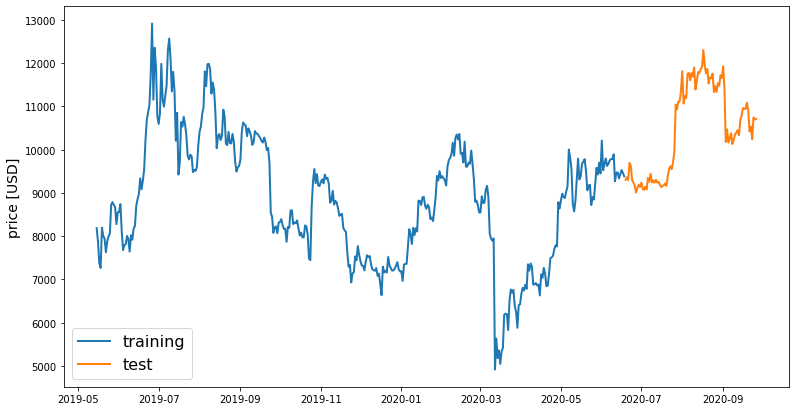

In [ ]:
line_plot(train[target_col], test[target_col], 'training', 'test', title='')

In [ ]:
def normalise_zero_base(df):
    return df / df.iloc[0] - 1

def normalise_min_max(df):
    return (df - df.min()) / (data.max() - df.min())

In [ ]:
def extract_window_data(df, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

In [ ]:
def prepare_data(df, target_col, window_len=10, zero_base=True, test_size=0.2):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

In [ ]:
def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [ ]:
np.random.seed(42)
window_len = 5
test_size = 0.2
zero_base = True
lstm_neurons = 100
epochs = 20
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

In [ ]:
train, test, X_train, X_test, y_train, y_test = prepare_data(
    hist, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

In [ ]:
model = build_lstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
history = model.fit(
    X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/20
13/13 [==============================] - 0s 5ms/step - loss: 0.0075
Epoch 2/20
13/13 [==============================] - 0s 5ms/step - loss: 0.0052
Epoch 3/20
13/13 [==============================] - 0s 4ms/step - loss: 0.0046
Epoch 4/20
13/13 [==============================] - 0s 5ms/step - loss: 0.0045
Epoch 5/20
13/13 [==============================] - 0s 5ms/step - loss: 0.0041
Epoch 6/20
13/13 [==============================] - 0s 5ms/step - loss: 0.0042
Epoch 7/20
13/13 [==============================] - 0s 5ms/step - loss: 0.0036
Epoch 8/20
13/13 [==============================] - 0s 5ms/step - loss: 0.0036
Epoch 9/20
13/13 [==============================] - 0s 5ms/step - loss: 0.0032
Epoch 10/20
13/13 [==============================] - 0s 5ms/step - loss: 0.0031
Epoch 11/20
13/13 [==============================] - 0s 5ms/step - loss: 0.0030
Epoch 12/20
13/13 [==============================] - 0s 5ms/step - loss: 0.0029
Epoch 13/20
13/13 [==============================

In [ ]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)

0.018846581907634573

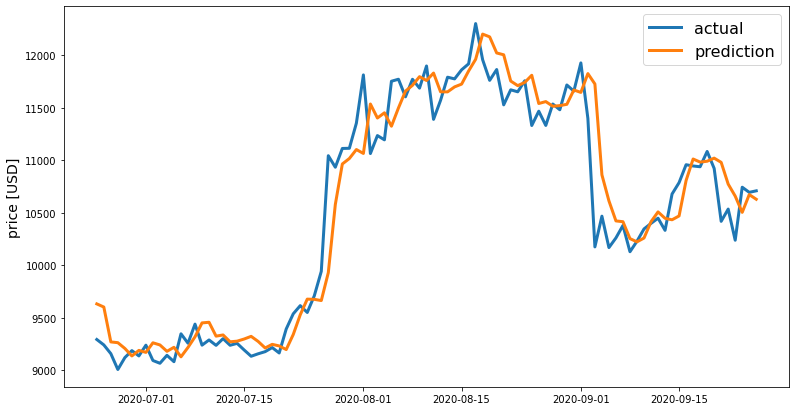

In [ ]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)